## Evaluation
Now I want to evaluate and play around with our new model. How well does it perform against MLB's? How well does it perform against Frontier League data

In [3]:
from pybaseball import statcast, cache
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import joblib
from tqdm import tqdm
cache.enable()

In [4]:
data_2023 = statcast('2023-04-01', '2023-07-18')

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [02:04<00:00,  1.14s/it]


In [5]:
columns = ['events', 'launch_speed', 'launch_angle', 'spray_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'batter']
features = ['launch_speed', 'launch_angle', 'spray_angle']
care_about = ['home_run', 'field_out', 'single', 'double', 'triple']
data_2023["spray_angle"] = np.arctan((data_2023["hc_x"]-125.42)/(198.27-data_2023["hc_y"]))*180/np.pi*.75
data = data_2023[data_2023['events'].isin(care_about)].loc[:, data_2023.columns.isin(columns)].dropna().reset_index(drop=True)

In [6]:
model = joblib.load('models/tuned-model.joblib')

le = LabelEncoder()

data.events = le.fit_transform(data.events)

In [7]:
data['Prediction'] = model.predict(data[features])

In [8]:
data['events'], data['Prediction'] = le.inverse_transform(data['events']), le.inverse_transform(data['Prediction'])

In [9]:
color_dict = {
    'home_run': 'red',
    'field_out': 'blue',
    'single': 'green',
    'double': 'orange',
    'triple': 'purple'
}

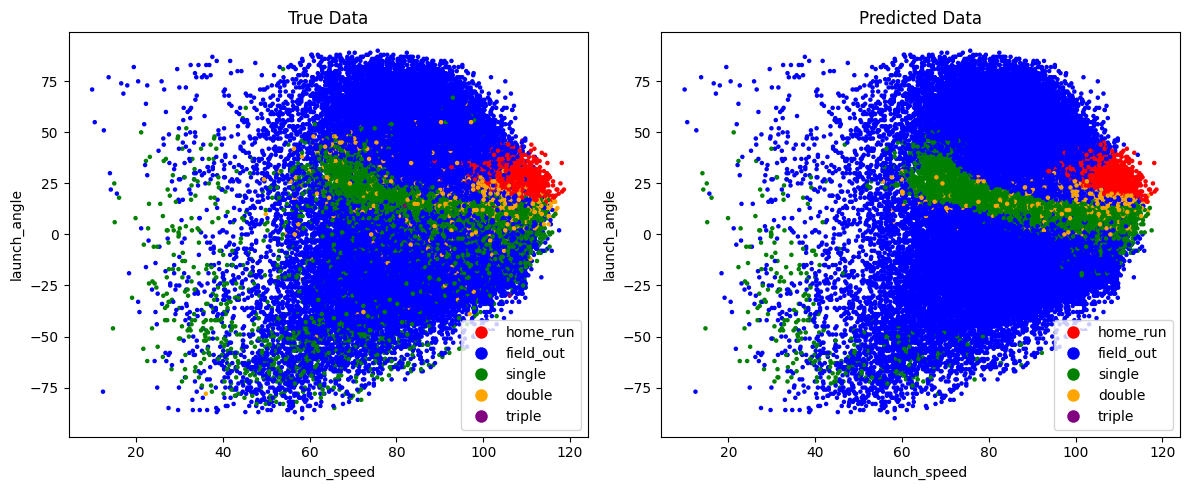

In [10]:
true_data, predicted_data = data, data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

scatter_true = ax1.scatter(
    true_data['launch_speed'],
    true_data['launch_angle'],
    c=true_data['events'].map(color_dict),
    s=5,
    label='2023 Data'
)
ax1.set_xlabel('launch_speed')
ax1.set_ylabel('launch_angle')
ax1.set_title('True Data')

scatter_pred = ax2.scatter(
    predicted_data['launch_speed'],
    predicted_data['launch_angle'],
    c=predicted_data['Prediction'].map(color_dict),
    s=5,
    label='Model\'s Predictions'
)
ax2.set_xlabel('launch_speed')
ax2.set_ylabel('launch_angle')
ax2.set_title('Predicted Data')


legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=event) for event, color in color_dict.items()]
ax1.legend(handles=legend_handles), ax2.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

In [11]:
accuracy = accuracy_score(data['events'], data['Prediction'])
precision = precision_score(data['events'], data['Prediction'], average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)

Accuracy: 0.7964503181894487
Precision: 0.784496802708437


C:\Users\kellyjc\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


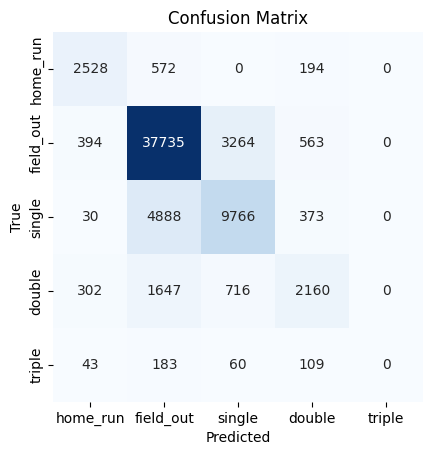

In [12]:
cm = confusion_matrix(data['events'], data.Prediction, labels=care_about)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=care_about, yticklabels=care_about)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [13]:
woba_weights = {'single': .886, 'double': 1.252, 'triple': 1.580, 'home_run': 2.023, 'field_out': 0, 'Single': .886, 'Double': 1.252, 'Triple': 1.580, 'HomeRun': 2.023, 'Out': 0}

def calculate_woba(df):
    xwOBAcon_values = []

    for index, row in df.iterrows():
        prob = model.predict_proba(row[features].values.reshape(1, -1))
        decoded_predictions = le.inverse_transform(range(len(model.classes_)))
        xwOBAcon = sum(prob[0][i] * woba_weights[decoded_predictions[i]] for i in range(len(decoded_predictions)))

        xwOBAcon_values.append(xwOBAcon)

    df['xwOBAcon'] = xwOBAcon_values
    return df


data = calculate_woba(data)

In [14]:
def calculate_xba(df):
    xba_values = []
    for index, row in df.iterrows():
        prob = model.predict_proba(row[features].values.reshape(1, -1))

        field_out_index = list(le.inverse_transform(model.classes_)).index('field_out')

        prob_field_out = prob[0][field_out_index]

        xba = 1 - prob_field_out

        xba_values.append(xba)

    df['xBA'] = xba_values
    return df

data = calculate_xba(data)

In [15]:
slg_weights = {'single': 1, 'double': 2, 'triple': 3, 'home_run': 4, 'field_out': 0}

def calculate_slg(df):
    xSLG_values = []

    for index, row in df.iterrows():
        prob = model.predict_proba(row[features].values.reshape(1, -1))
        decoded_predictions = le.inverse_transform(range(len(model.classes_)))
        xslg = sum(prob[0][i] * woba_weights[decoded_predictions[i]] for i in range(len(decoded_predictions)))

        xSLG_values.append(xslg)

    df['xSLG'] = xSLG_values
    return df

data = calculate_slg(data)

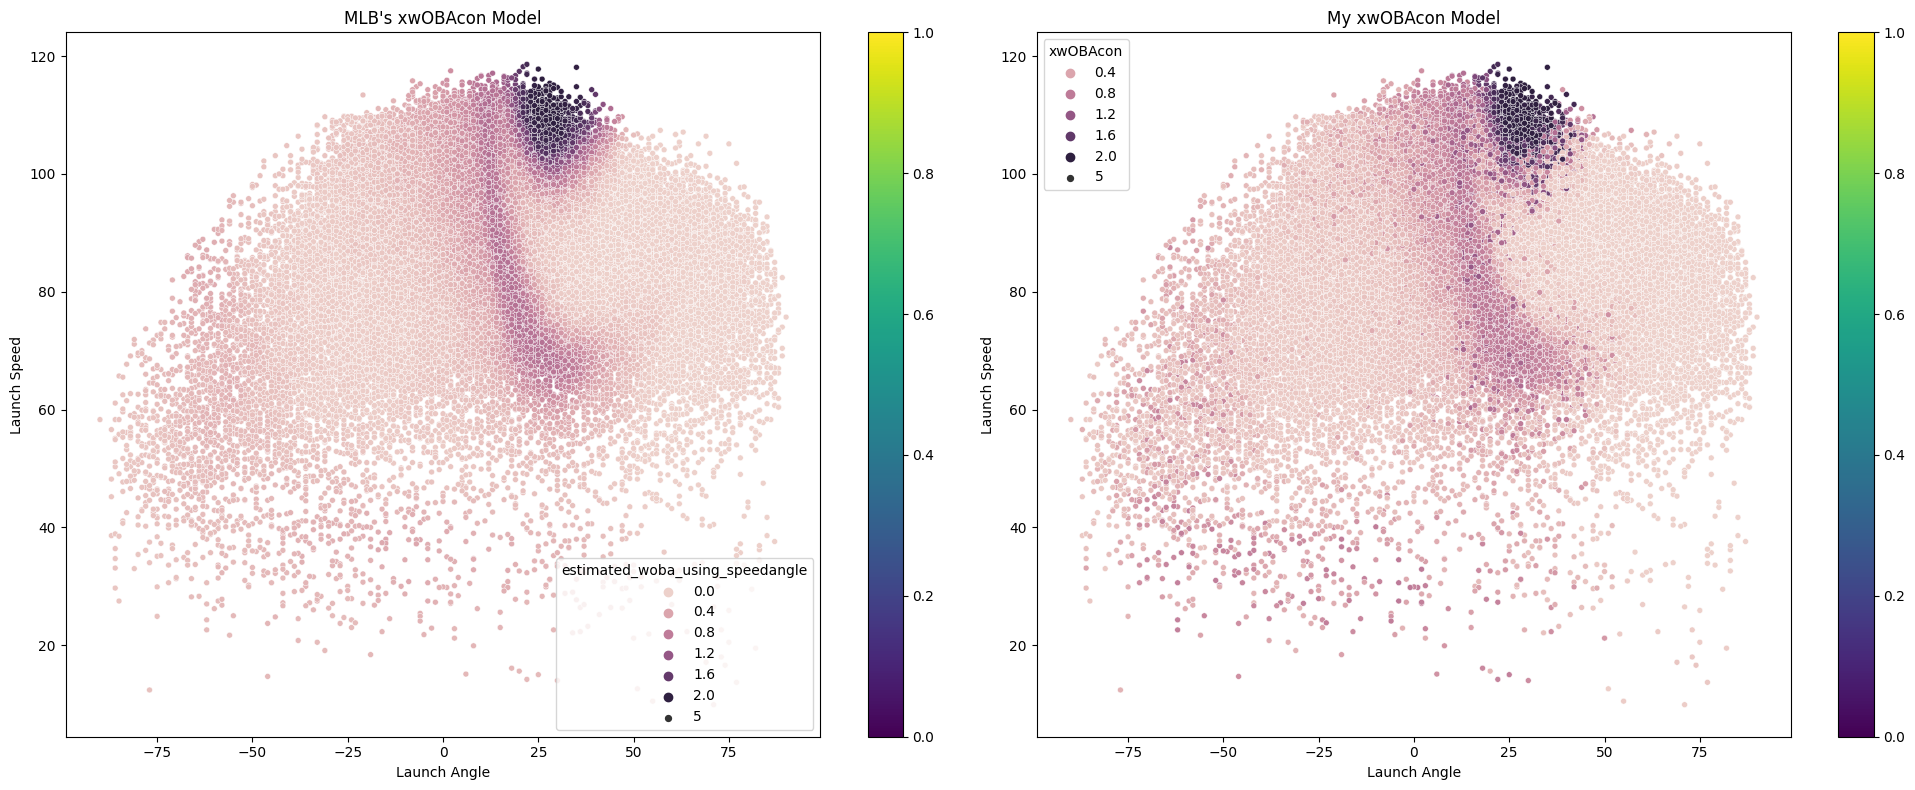

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

data['estimated_woba_using_speedangle'] = data['estimated_woba_using_speedangle'].astype(float)
data['xwOBAcon'] = data['xwOBAcon'].astype(float)

scatter1 = sns.scatterplot(data=data, x='launch_angle', y='launch_speed', hue='estimated_woba_using_speedangle', size=5, ax=axes[0])
plt.colorbar(scatter1.collections[0], ax=axes[0])
axes[0].set_title("MLB's xwOBAcon Model")
axes[0].set_xlabel('Launch Angle')
axes[0].set_ylabel('Launch Speed')

scatter2 = sns.scatterplot(data=data, x='launch_angle', y='launch_speed', hue='xwOBAcon', size=5, ax=axes[1])
plt.colorbar(scatter2.collections[0], ax=axes[1])
axes[1].set_title('My xwOBAcon Model')
axes[1].set_xlabel('Launch Angle')
axes[1].set_ylabel('Launch Speed')

plt.tight_layout()

plt.show()

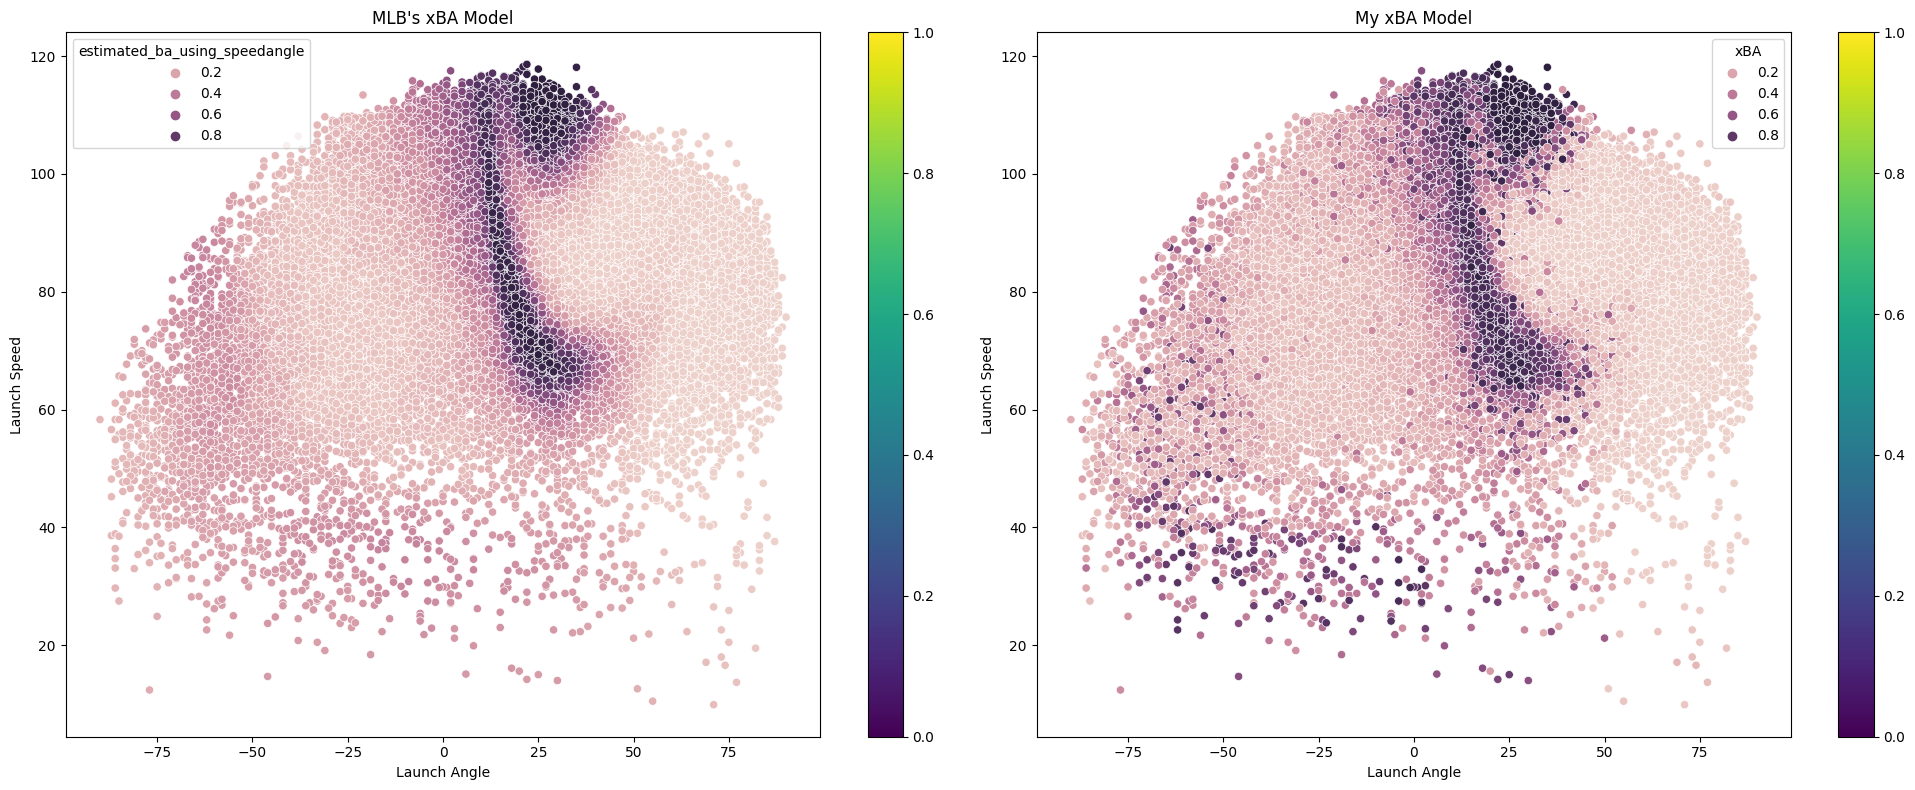

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

data['estimated_ba_using_speedangle'] = data['estimated_ba_using_speedangle'].astype(float)
data['xBA'] = data['xBA'].astype(float)

scatter1 = sns.scatterplot(data=data, x='launch_angle', y='launch_speed', hue='estimated_ba_using_speedangle', ax=axes[0])
plt.colorbar(scatter1.collections[0], ax=axes[0])
axes[0].set_title("MLB's xBA Model")
axes[0].set_xlabel('Launch Angle')
axes[0].set_ylabel('Launch Speed')

scatter2 = sns.scatterplot(data=data, x='launch_angle', y='launch_speed', hue='xBA', ax=axes[1])
plt.colorbar(scatter2.collections[0], ax=axes[1])
axes[1].set_title('My xBA Model')
axes[1].set_xlabel('Launch Angle')
axes[1].set_ylabel('Launch Speed')

plt.tight_layout()

plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error

data['xISO'] = data['xSLG'] - data['xBA']
mae_xba = mean_absolute_error(data['xBA'], data['estimated_ba_using_speedangle'])
mae_xwoba = mean_absolute_error(data['xwOBAcon'], data['estimated_woba_using_speedangle'])
print("Mean Absolute Error for xBA:", mae_xba)
print("Mean Absolute Error for xwOBAcon:", mae_xwoba)

Mean Absolute Error for xBA: 0.08145806888534311
Mean Absolute Error for xwOBAcon: 0.10638747365248086


In [19]:
mean_xba = data['xBA'].mean()
mlb_xba = data['estimated_ba_using_speedangle'].mean()
mean_woba = data['xwOBAcon'].mean()
mlb_woba = data['estimated_woba_using_speedangle'].mean()

print('My model xBA mean: ', mean_xba)
print('MLB xBA mean: ', mlb_xba)
print('Difference: ', mean_xba - mlb_xba, '\n')
print('My model xwOBA mean: ', mean_woba)
print('MLB xwOBA mean: ', mlb_woba)
print('Difference: ', mean_woba - mlb_woba, '\n')

My model xBA mean:  0.357473678417214
MLB xBA mean:  0.33844607566346974
Difference:  0.019027602753744266 

My model xwOBA mean:  0.40639087608930696
MLB xwOBA mean:  0.3891672287759373
Difference:  0.017223647313369672 



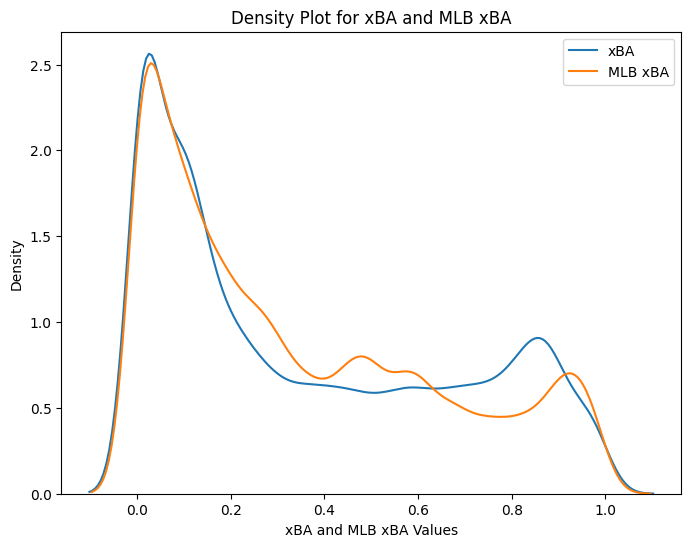

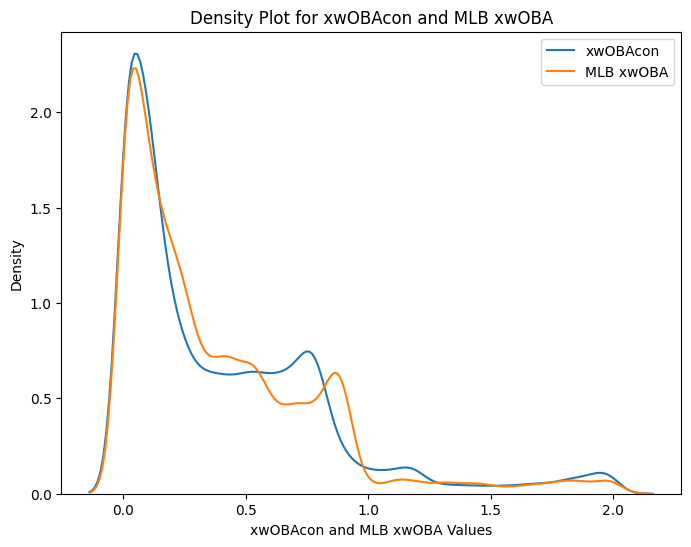

In [20]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data['xBA'], label='xBA')
sns.kdeplot(data['estimated_ba_using_speedangle'], label='MLB xBA')
plt.xlabel('xBA and MLB xBA Values')
plt.ylabel('Density')
plt.title('Density Plot for xBA and MLB xBA')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(data['xwOBAcon'], label='xwOBAcon')
sns.kdeplot(data['estimated_woba_using_speedangle'], label='MLB xwOBA')
plt.xlabel('xwOBAcon and MLB xwOBA Values')
plt.ylabel('Density')
plt.title('Density Plot for xwOBAcon and MLB xwOBA')
plt.legend()
plt.show()

In [21]:
from pybaseball import playerid_reverse_lookup

player_ids = data.batter.unique()
id_data = playerid_reverse_lookup(player_ids, key_type='mlbam')

In [22]:
id_data['batter_name'] = id_data['name_first'] + ' ' + id_data['name_last']

In [23]:
id_data['batter_name'] = id_data['batter_name'].str.title()
    
id_data = id_data[['batter_name', 'key_mlbam']]

In [24]:
data = pd.merge(data, id_data, left_on='batter', right_on='key_mlbam', how='left')

In [25]:
data

batter     events  launch_speed  launch_angle  \
0      457705     single          95.9            -4   
1      605137  field_out          81.5            -4   
2      665926     single          95.6           -11   
3      647304   home_run         105.2            29   
4      608070     single          88.0            15   
...       ...        ...           ...           ...   
65522  664034  field_out         102.5           -23   
65523  543939  field_out          91.7            31   
65524  677594     single          88.8             2   
65525  608070     single         103.3             8   
65526  642708  field_out          90.1           -14   

       estimated_ba_using_speedangle  estimated_woba_using_speedangle  \
0                              0.283                            0.274   
1                              0.163                            0.159   
2                              0.186                            0.175   
3                              0.889                            1.769   
4                              0.974                            0.909   
...                              ...                              ...   
65522                          0.129                            0.116   
65523                          0.083                            0.136   
65524                          0.320                            0.288   
65525                          0.697                            0.627   
65526                          0.109                            0.098   

       spray_angle Prediction  xwOBAcon       xBA      xSLG      xISO  \
0       -17.124789  field_out  0.313866  0.346626  0.313866 -0.032760   
1        17.106097  field_out  0.134602  0.146689  0.134602 -0.012087   
2        -10.94962  field_out  0.133301  0.143958  0.133301 -0.010657   
3        36.242639   home_run  1.980928  0.992057  1.980928  0.988871   
4        19.094668     single  0.759111  0.847039  0.759111 -0.087928   
...            ...        ...       ...       ...       ...       ...   
65522   -28.286096  field_out  0.108592  0.111473  0.108592 -0.002881   
65523   -11.558686  field_out  0.070937  0.053024  0.070937  0.017912   
65524   -24.440228  field_out  0.411892  0.457646  0.411892 -0.045754   
65525    16.668773     single  0.644625  0.702692  0.644625 -0.058067   
65526   -26.461881  field_out  0.124515  0.132136  0.124515 -0.007620   

            batter_name  key_mlbam  
0      Andrew Mccutchen   457705.0  
1             Josh Bell   605137.0  
2        Andrés Giménez   665926.0  
3           Josh Naylor   647304.0  
4          José Ramírez   608070.0  
...                 ...        ...  
65522         Ty France   664034.0  
65523       Kolten Wong   543939.0  
65524   Julio Rodríguez   677594.0  
65525      José Ramírez   608070.0  
65526      Amed Rosario   642708.0  

[65527 rows x 14 columns]

In [26]:
leaderboard = pd.DataFrame(columns=['batter', 'xwOBAcon_model', 'xwOBAcon_mlb', 'xwOBAcon_dif', 'xba_model', 'xba_mlb', 'xba_dif', 'slg_model', 'iso_model'])


for batter in data['batter_name'].unique():
    batter_data = data[data['batter_name'] == batter]

    new_row = {
        'batter': batter,
        'xwOBAcon_model': batter_data['xwOBAcon'].mean(),
        'xwOBAcon_mlb': batter_data['estimated_woba_using_speedangle'].mean(),
        'xba_model': batter_data['xBA'].mean(),
        'xba_mlb': batter_data['estimated_ba_using_speedangle'].mean(),
        'slg_model': batter_data['xSLG'].mean(),
        'iso_model': batter_data['xISO'].mean()
    }
    
    leaderboard = leaderboard.append(new_row, ignore_index=True)

leaderboard['xwOBAcon_dif'] = leaderboard['xwOBAcon_model'] - leaderboard['xwOBAcon_mlb']
leaderboard['xba_dif'] = leaderboard['xba_model'] - leaderboard['xba_mlb']

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(new_row, ignore_index=True)
C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\1798541435.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

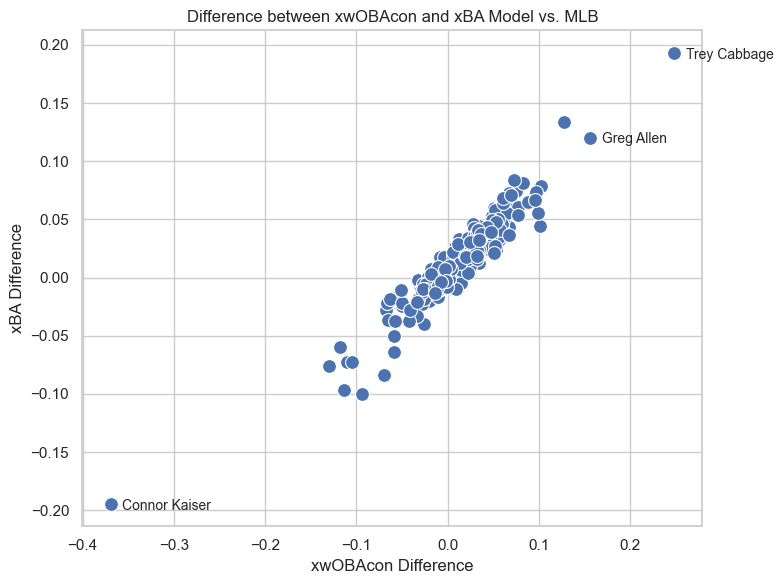

In [78]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x='xwOBAcon_dif', y='xba_dif', data=leaderboard, hue=None, palette='viridis', s=100)

outliers = leaderboard[(leaderboard['xwOBAcon_dif'].abs() > 0.14) | (leaderboard['xba_dif'].abs() > 0.2)]
for idx, row in outliers.iterrows():
    ax.text(row['xwOBAcon_dif'] + .013, row['xba_dif'] - .005, row['batter'], fontsize=10)

plt.xlabel('xwOBAcon Difference')
plt.ylabel('xBA Difference')
plt.title('Difference between xwOBAcon and xBA Model vs. MLB')
plt.tight_layout()
plt.show()

In [28]:
fl_data = pd.read_csv('../AutomatedPitchTagging/master autoTagged 2023-07-19.csv').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

C:\Users\kellyjc\AppData\Local\Temp\ipykernel_12000\4230123816.py:1: DtypeWarning: Columns (72) have mixed types. Specify dtype option on import or set low_memory=False.
  fl_data = pd.read_csv('../AutomatedPitchTagging/master autoTagged 2023-07-19.csv').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)


In [29]:
fl_data

PitchNo        Date        Time  PAofInning  PitchofPA      Pitcher  \
0             1  2023-05-26  7:07:13 PM           1          1    Ray Weber   
1             2  2023-05-26  7:07:27 PM           1          2    Ray Weber   
2             3  2023-05-26  7:07:42 PM           1          3    Ray Weber   
3             4  2023-05-26  7:08:19 PM           2          1    Ray Weber   
4             5  2023-05-26  7:08:36 PM           2          2    Ray Weber   
...         ...         ...         ...         ...        ...          ...   
200848      256  2023-07-06  9:33:59 PM           2          6  Lukas Young   
200849      257  2023-07-06  9:34:34 PM           3          1  Lukas Young   
200850      258  2023-07-06  9:35:16 PM           4          1  Lukas Young   
200851      259  2023-07-06  9:35:37 PM           4          2  Lukas Young   
200852      260  2023-07-06  9:35:59 PM           4          3  Lukas Young   

          PitcherId  PitcherThrows             PitcherTeam           Batter  \
0               NaN            0.0   Trois-Rivieres Aigles     Eric Jenkins   
1               NaN            0.0   Trois-Rivieres Aigles     Eric Jenkins   
2               NaN            0.0   Trois-Rivieres Aigles     Eric Jenkins   
3               NaN            0.0   Trois-Rivieres Aigles   Quentin Holmes   
4               NaN            0.0   Trois-Rivieres Aigles   Quentin Holmes   
...             ...            ...                     ...              ...   
200848  lukayo00wwt            0.0  Washington Wild Things   Junior Martina   
200849  lukayo00wwt            0.0  Washington Wild Things  Peyton Isaacson   
200850  lukayo00wwt            0.0  Washington Wild Things   Micah Yonamine   
200851  lukayo00wwt            0.0  Washington Wild Things   Micah Yonamine   
200852  lukayo00wwt            0.0  Washington Wild Things   Micah Yonamine   

        ... yt_HitSpinConfidence yt_EffectiveBattingSpeed yt_ReleaseAccuracy  \
0       ...                  NaN                      NaN               high   
1       ...                  NaN                      NaN               high   
2       ...             0.996774                46.579988               high   
3       ...                  NaN                      NaN               high   
4       ...                  NaN                      NaN               high   
...     ...                  ...                      ...                ...   
200848  ...                  NaN                      NaN               high   
200849  ...                  NaN                      NaN               high   
200850  ...                  NaN                      NaN               high   
200851  ...                  NaN                      NaN               high   
200852  ...                  NaN                      NaN               high   

       yt_ZoneAccuracy  yt_SeamLat yt_SeamLong  yt_ReleaseDistance  \
0                 high   84.096465   -0.049282           54.733687   
1                 high   78.879738    5.148222           54.808511   
2                 high   82.078869    3.495183           54.691982   
3                 high   80.761704   -1.231209           54.680451   
4                 high   30.357252   35.687775           54.885657   
...                ...         ...         ...                 ...   
200848             low         NaN         NaN           54.987439   
200849             low         NaN         NaN           55.970178   
200850          medium   56.804924  -25.494305           55.579176   
200851             low         NaN         NaN           54.943111   
200852             low         NaN         NaN           54.830769   

                Catcher    CatcherId             CatcherTeam  
0       Ricardo Sanchez          NaN  Trois rivieres aigles   
1       Ricardo Sanchez          NaN  Trois rivieres aigles   
2       Ricardo Sanchez          NaN  Trois rivieres aigles   
3       Ricardo Sanchez          NaN  Trois rivieres aig

In [31]:
fl_data = fl_data.rename(columns={'Angle': 'launch_angle', 'ExitSpeed': 'launch_speed', 'Direction': 'spray_angle'})
fl_data = fl_data[fl_data[['PlayResult']].notna().all(axis=1)]

fl_data = calculate_woba(fl_data)
fl_data = calculate_xba(fl_data)
fl_data = calculate_slg(fl_data)

In [51]:
batter_counts = fl_data['Batter'].value_counts()
batters_appear_100_plus = batter_counts[batter_counts >= 100].index.tolist()
fl_data = fl_data[fl_data['Batter'].isin(batters_appear_100_plus)]

woba_weights = {'single': .886, 'double': 1.252, 'triple': 1.580, 'home_run': 2.023, 'field_out': 0, 'Single': .886, 'Double': 1.252, 'Triple': 1.580, 'HomeRun': 2.023, 'Out': 0, 'Walk': .705}

def calculate_real_woba(fl_data):
    total_woba = 0
    
    play_result_counts = fl_data['PlayResult'].value_counts()
    total_plate_appearances = 0
    for play_result, count in play_result_counts.items():
        total_plate_appearances += count
        if play_result in woba_weights:
            woba_weight = woba_weights[play_result]
            total_woba += count * woba_weight
        try:
            real_woba = total_woba / total_plate_appearances
        except ZeroDivisionError:
            return

    return real_woba

hits = ['Single', 'Double', 'Triple', 'Home Run']

def calculate_real_ba(fl_data):
    play_result_counts = fl_data['PlayResult'].value_counts()
    at_bats = play_result_counts.sum()
    num_hits = play_result_counts[play_result_counts.index.isin(hits)].sum()

    if 'Sacrifice' in play_result_counts:
        at_bats -= play_result_counts['Sacrifice']

    try:
        real_ba = num_hits / at_bats
    except ZeroDivisionError:
        return None

    return real_ba

batter_to_ba = {}
batter_to_woba = {}

for batter in fl_data['Batter'].unique():
    b_data = fl_data[fl_data['Batter'] == batter]
    batter_to_woba[batter] = calculate_real_woba(b_data)
    batter_to_ba[batter] = calculate_real_ba(b_data)

In [91]:
leaderboard_savant = pd.DataFrame(columns=['batter', 'wOBA', 'xwOBA', 'dif_wOBA', 'BA', 'xBA', 'dif_BA'])
leaderboard_savant['batter'] = fl_data['Batter'].unique()

for batter in leaderboard_savant['batter'].unique():
    batter_data = fl_data[fl_data['Batter'] == batter]
    leaderboard_savant.loc[leaderboard_savant['batter'] == batter, 'wOBA'] = batter_to_woba.get(batter)
    leaderboard_savant.loc[leaderboard_savant['batter'] == batter, 'xwOBA'] = batter_data['xwOBAcon'].mean()
    leaderboard_savant.loc[leaderboard_savant['batter'] == batter, 'BA'] = batter_to_ba.get(batter)
    leaderboard_savant.loc[leaderboard_savant['batter'] == batter, 'xBA'] = batter_data['xBA'].mean()
leaderboard_savant['dif_wOBA'] = leaderboard_savant['xwOBA'] - leaderboard_savant['wOBA']
leaderboard_savant['dif_BA'] = leaderboard_savant['xBA'] - leaderboard_savant['BA']

team_to_xwoba = {}
team_to_xba = {}
for team in fl_data['BatterTeam'].unique():
    team_data = fl_data[fl_data['BatterTeam'] == team]
    team_to_xwoba[team] = team_data['xwOBAcon'].mean()
    team_to_xba[team] = team_data['xBA'].mean()

    

0.3269559333429617

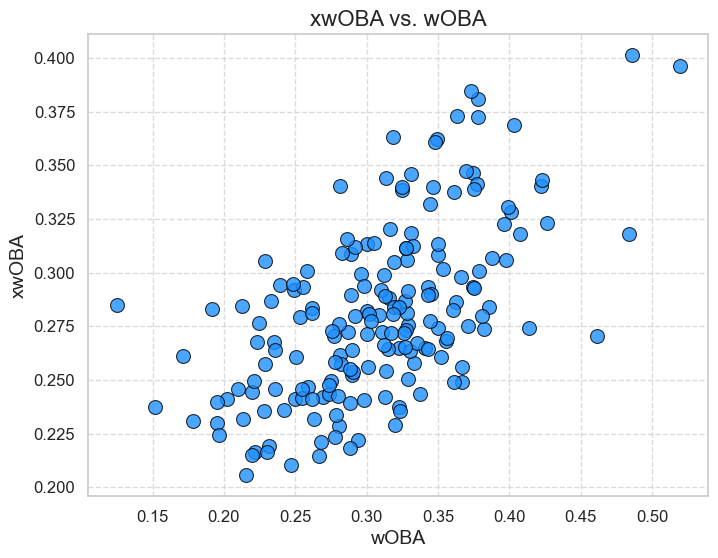

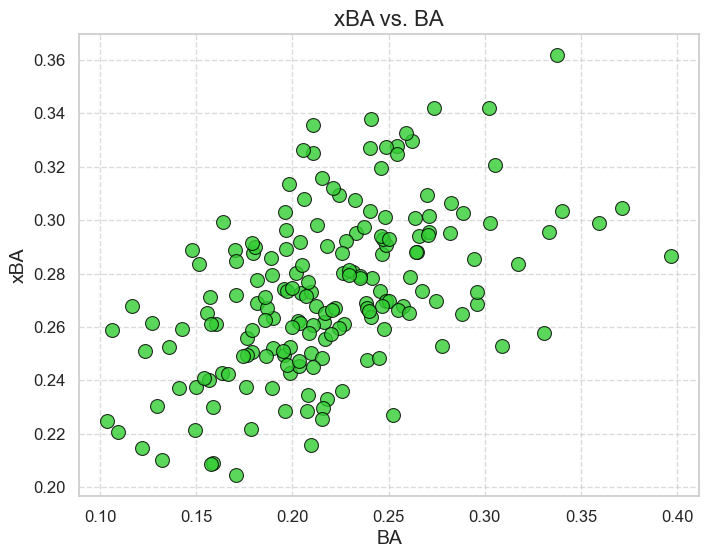

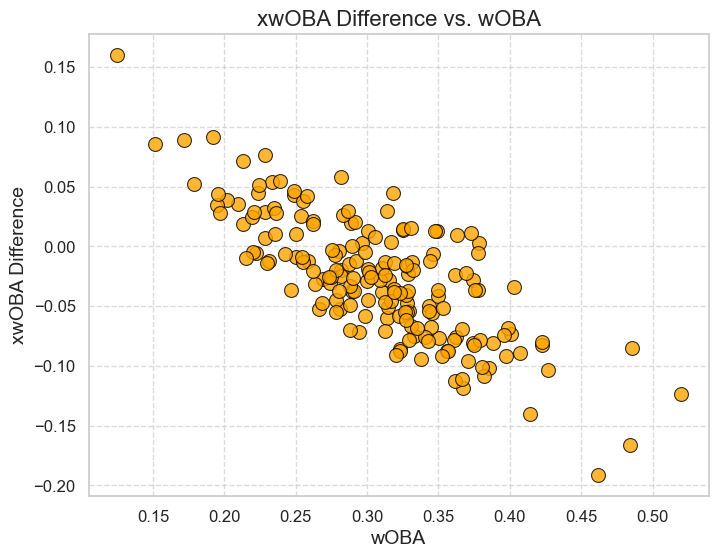

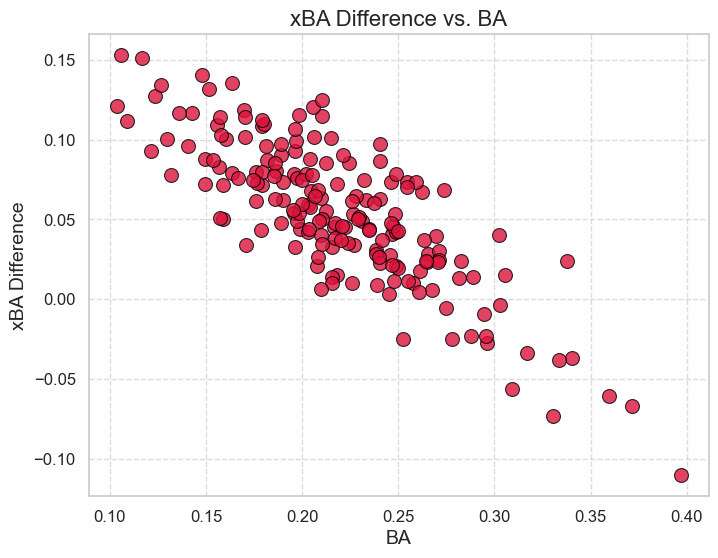

In [72]:
sns.set(style="whitegrid")

# Scatter plot for xwOBA vs. wOBA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='wOBA', y='xwOBA', data=leaderboard_savant, s=100, color='dodgerblue', edgecolor='black', alpha=0.8)
plt.xlabel('wOBA', fontsize=14)
plt.ylabel('xwOBA', fontsize=14)
plt.title('xwOBA vs. wOBA', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Scatter plot for BA vs. xBA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='BA', y='xBA', data=leaderboard_savant, s=100, color='limegreen', edgecolor='black', alpha=0.8)
plt.xlabel('BA', fontsize=14)
plt.ylabel('xBA', fontsize=14)
plt.title('xBA vs. BA', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Scatter plot for xwOBA difference vs. wOBA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='wOBA', y='dif_wOBA', data=leaderboard_savant, s=100, color='orange', edgecolor='black', alpha=0.8)
plt.xlabel('wOBA', fontsize=14)
plt.ylabel('xwOBA Difference', fontsize=14)
plt.title('xwOBA Difference vs. wOBA', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

# Scatter plot for xBA difference vs. BA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='BA', y='dif_BA', data=leaderboard_savant, s=100, color='crimson', edgecolor='black', alpha=0.8)
plt.xlabel('BA', fontsize=14)
plt.ylabel('xBA Difference', fontsize=14)
plt.title('xBA Difference vs. BA', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In [89]:
leaderboard_savant[leaderboard_savant['xwOBA'] == leaderboard_savant['xwOBA'].min()]

batter      wOBA     xwOBA  dif_wOBA        BA       xBA  \
129  Abraham Sequera  0.215321  0.205549 -0.009773  0.170732  0.204476   

       dif_BA  
129  0.033744